# Match gas network to buses structure
#### since 'isbothdirection' value of most pipe in IGG and IGGxxx dataset is 0, I suppose all the pipe with direction 0 is real single direction. Therefore pipes with 'isbothdirection' = 1 will be split to two single direction reccord in table  
#### only considering cross border gas network pipe
        - original point level match is impossible. If we match a buses to a point or several point in original gas network level, there will be at least hundreds of possible unweighted shorest path between two buses (this is under the condition that each buses just match to one point in orginal gas network, things will be worse if each buses has several matched point)
        - since matched points of a bus will not exactly at the border of bus' region, therefore when we calculate unweigthed shorest path between two buses in above, we might consider the path have different inside region path and same corss border path (several shorest paths in above process are almost the same but just have one different pipe ) 

# 

In [1]:
import pandas as pd
import geopandas as gpd
from Utility import string2list
from shapely.geometry import Point, MultiPoint
import geoplot
import networkx as nx
from shapely.geometry import LineString
import geoplot.crs as gcrs
import matplotlib.pyplot as plt

Loading BokehJS ...

Loading BokehJS ...

# Loading& Matching and Network creating Functions

In [182]:
def create_cross_regions_network(Final_dataset,output):
    # multi same direction pipes between two regions will combine to one pipe
    bus = output[['buses','name']]
    
    bus.columns = ['buses_start','name']
    cross_buses_gas_network = Final_dataset.merge(bus,left_on='point1_name',right_on='name')
    
    bus.columns = ['buses_destination','name']
    cross_buses_gas_network = cross_buses_gas_network.merge(bus,left_on='point2_name',right_on='name')

    cross_buses_gas_network = cross_buses_gas_network[cross_buses_gas_network.buses_start \
                                                      != cross_buses_gas_network.buses_destination]
    cross_buses_gas_network.reset_index(drop=True,inplace=True)

    #cbgn_no_duplicate = cross_buses_gas_network.groupby(['buses_x','buses_y']).sum().reset_index()
    return cross_buses_gas_network

def concat_gdf(gdf_list, crs = 'EPSG:4326'):
    return gpd.GeoDataFrame(pd.concat(gdf_list),crs=crs)

def load_data(path = '../resources/gas_network_INETNO.csv', sep = ';' ):
    df = pd.read_csv(path,sep=sep)

    df.long = df.long.apply(eval)
    df.lat = df.lat.apply(eval)
    df.node_id = df.node_id.apply(eval)

    both_direct_df = df[df.is_bothDirection==1].reset_index(drop=True)
    both_direct_df.node_id = both_direct_df.node_id.apply(lambda x: [x[1],x[0]])
    both_direct_df.long = both_direct_df.long.apply(lambda x: [x[1],x[0]])
    both_direct_df.lat = both_direct_df.lat.apply(lambda x: [x[1],x[0]])

    df_singledirect = pd.concat([df,both_direct_df]).reset_index(drop=True)
    df_singledirect.drop('is_bothDirection',axis=1)

    df['point1'] = df.apply(lambda x: Point((x['long'][0],x['lat'][0])),axis=1)
    df['point2'] = df.apply(lambda x: Point((x['long'][1],x['lat'][1])),axis=1)



    df['point1_name']=df.node_id.str[0]
    df['point2_name']=df.node_id.str[1]

    #df[df.point1_name == 'INET_N_741']
    Final_dataset = df.copy()
    
    part1 = Final_dataset[['point1','point1_name']]
    part2 = Final_dataset[['point2','point2_name']]

    part1.columns = ['geometry','name']
    part2.columns = ['geometry','name']
    points = [part1,part2]

    points = concat_gdf(points)

    points = points.drop_duplicates()
    points.reset_index(drop=True, inplace= True)
    
    points['key'] = points['geometry'].apply(lambda x: str(list(x.coords)[0]))
    points['name'] = ['INETNO_'+str(i) for i in range(len(points))]
    points = points.groupby('key').first()
    

    Final_dataset['node_id'] = Final_dataset.apply(lambda x : [points.loc[str(list(x['point1'].coords)[0]),'name'],
                                  points.loc[str(list(x['point2'].coords)[0]),'name']],axis=1)
    
    Final_dataset['point1_name']=Final_dataset.node_id.str[0]
    Final_dataset['point2_name']=Final_dataset.node_id.str[1]
    points.reset_index(drop = True, inplace = True)
    #Final_dataset.drop(['node_id','long','lat','source_id','country_code'],axis=1,inplace=True)
    return Final_dataset,points
# identical point name has identical point coordinate 
# should we consider start year? because inside pipes group in which have same start and end points 
# new pipes may be the successor of old pipes


# assgin point to buses
from tqdm import tqdm
def assign_points2buses(input_points, buses_region):
    points = input_points.copy()
    points['buses'] = None
    buses_list = set(buses_region.name)
    for buses in tqdm(buses_list):
        mask = buses_region[buses_region.name == buses]
        index = gpd.clip(points,mask).index
        if len(index)!=0:
            points.loc[index,'buses'] = buses
    
    return points

# Visualization Functions

In [183]:
def view(dataset,point_list,
         offshore_path = 'region/regions_offshore_elec_s_37.geojson', 
         onshore_path = 'region/regions_onshore_elec_s_37.geojson'):
    
    buses_region_offshore = gpd.read_file(offshore_path) 
    buses_region_onshore = gpd.read_file(onshore_path)
    buses_region = concat_gdf([buses_region_offshore,buses_region_onshore])
    buses_region = buses_region.dissolve(by='name', aggfunc='sum')
    buses_region = buses_region.reset_index()

    output = assign_points2buses(point_list,buses_region) 
    cbgn_no_duplicate=create_cross_regions_network(dataset,output)
    final = create_view_object(cbgn_no_duplicate,buses_region)
    view_final_dataset(final,buses_region)

def create_view_object(cbgn_no_duplicate,buses_region):
    cbgn_no_duplicate=cbgn_no_duplicate.merge(buses_region,left_on='buses_start',right_on='name')
    cbgn_no_duplicate=cbgn_no_duplicate.merge(buses_region,left_on='buses_destination',right_on='name')
    cbgn_no_duplicate.geometry_x=cbgn_no_duplicate.geometry_x.apply(lambda x: x.centroid)
    cbgn_no_duplicate.geometry_y=cbgn_no_duplicate.geometry_y.apply(lambda x: x.centroid)
    cbgn_no_duplicate['geometry']=list(zip(cbgn_no_duplicate['geometry_x'],cbgn_no_duplicate['geometry_y']))
    final = cbgn_no_duplicate[['buses_start', 'buses_destination', 'Capacity_GWh_h', 'geometry']]
    final['geometry']= final['geometry'].apply(LineString)
    final=gpd.GeoDataFrame(final,crs='EPSG:4326')
    return final

def view_final_dataset(final,buses_region):
    eu=gpd.read_file('salt_cave/eu_shapes/country_shapes.geojson')
    ax = geoplot.webmap(eu,projection=gcrs.WebMercator(),figsize=(20,20),alpha=0.5)
    geoplot.choropleth(buses_region, hue='name',ax=ax,alpha=0.2,edgecolor='red', linewidth=2)
    #geoplot.polyplot(buses_region,ax=ax,edgecolor='red')
    geoplot.sankey(
    final, scale='Capacity_GWh_h', hue='Capacity_GWh_h', cmap='viridis', ax=ax,legend=True,
        legend_var='hue')

# Matching result example

In [199]:
# load region data
buses_region_offshore = gpd.read_file('region/regions_offshore_elec_s_37.geojson') 
buses_region_onshore = gpd.read_file('region/regions_onshore_elec_s_37.geojson')
buses_region = concat_gdf([buses_region_offshore,buses_region_onshore])
buses_region = buses_region.dissolve(by='name', aggfunc='sum')
buses_region = buses_region.reset_index()

# load pipe data and create region network
IGGIENL_dataset,IGGIENL_points = load_data()
IGGIENL_output = assign_points2buses(IGGIENL_points,buses_region) 
cbgn_no_duplicate=create_cross_regions_network(IGGIENL_dataset,IGGIENL_output)

# have a look of the result
cbgn_no_duplicate[['buses_start','buses_destination','Capacity_GWh_h']].head()

100%|██████████| 37/37 [00:01<00:00, 26.15it/s]


buses_start buses_destination  Capacity_GWh_h
0       PT0 0             ES0 0        7.312500
1       RO0 0             HU0 0        7.083333
2       IT0 0             AT0 0        2.684722
3       ES0 0             FR0 0        7.521020
4       GB5 0             NL0 0       11.737667

In [195]:
def simple_distance(buses_region):
    #calculate center coordinate
    buses_region['center'] = buses_region.to_crs('EPSG:3857').centroid.to_crs('EPSG:4326')
    buses_region['center'] = buses_region['center'].apply(lambda x: list(x.coords)[0])
    
    data = {'buses_start':[],'buses_start_center':[],'buses_destination':[],'buses_destination_center':[],'distance':[]}
    for i in range(len(buses_region)):
        for j in range(len(buses_region)):
            if i==j:
                continue
            data['buses_start'].append(buses_region.loc[i,'name'])
            data['buses_start_center'].append(buses_region.loc[i,'center'])
            
            data['buses_destination'].append(buses_region.loc[j,'name'])
            data['buses_destination_center'].append(buses_region.loc[j,'center'])
            
            data['distance'].append(geopy.distance.distance(lonlat(*buses_region.loc[i,'center']), 
                                                       lonlat(*buses_region.loc[j,'center'])).kilometers)
    return pd.DataFrame(data)
    

In [196]:
df = simple_distance(buses_region)
cbgn_no_duplicate.merge(df, left_on=['buses_start','buses_destination'],
                            right_on = ['buses_start','buses_destination'])

In [204]:
f = pd.read_csv('../resources/gas_network_INETNO.csv',sep=';')

In [206]:
f[f.id == 'INET_PL_1231']

id                       name         source_id  \
69   INET_PL_1231  Cordoba_AlcazarDeSanJuan1   ['INET_PL_123']   
731  INET_PL_1231       unknown_FR_1_Palleau  ['INET_PL_1231']   

                          node_id              lat               long  \
69   ['INET_N_328', 'INET_N_330']   [38.19, 38.28]  [-3.7803, -3.386]   
731  ['INET_N_432', 'INET_N_433']  [46.55, 46.958]   [4.35, 5.028608]   

     country_code  is_bothDirection  lat_mean  length_km  long_mean  \
69   ['ES', 'ES']               0.0    38.235  35.874473  -3.583150   
731  ['FR', 'FR']               0.0    46.754  68.803027   4.689304   

     max_pressure_bar  num_compressor  start_year  Capacity_GWh_h  diameter_mm  
69               75.0             0.0        1983       22.361833          NaN  
731              75.0             0.0        1983       19.054428          NaN

In [16]:
INETnew_dataset,INETnew_points = load_data(path = 'data/gas_network_dataset_inetnew.csv')
INETnew_output = assign_points2buses(INETnew_points,buses_region) 
INETnew_cbgn_no_duplicate=create_cross_regions_network(INETnew_dataset,INETnew_output)

100%|██████████| 37/37 [00:01<00:00, 29.27it/s]


# Visualization

100%|██████████| 37/37 [00:01<00:00, 23.30it/s]
/Users/wenruizhou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


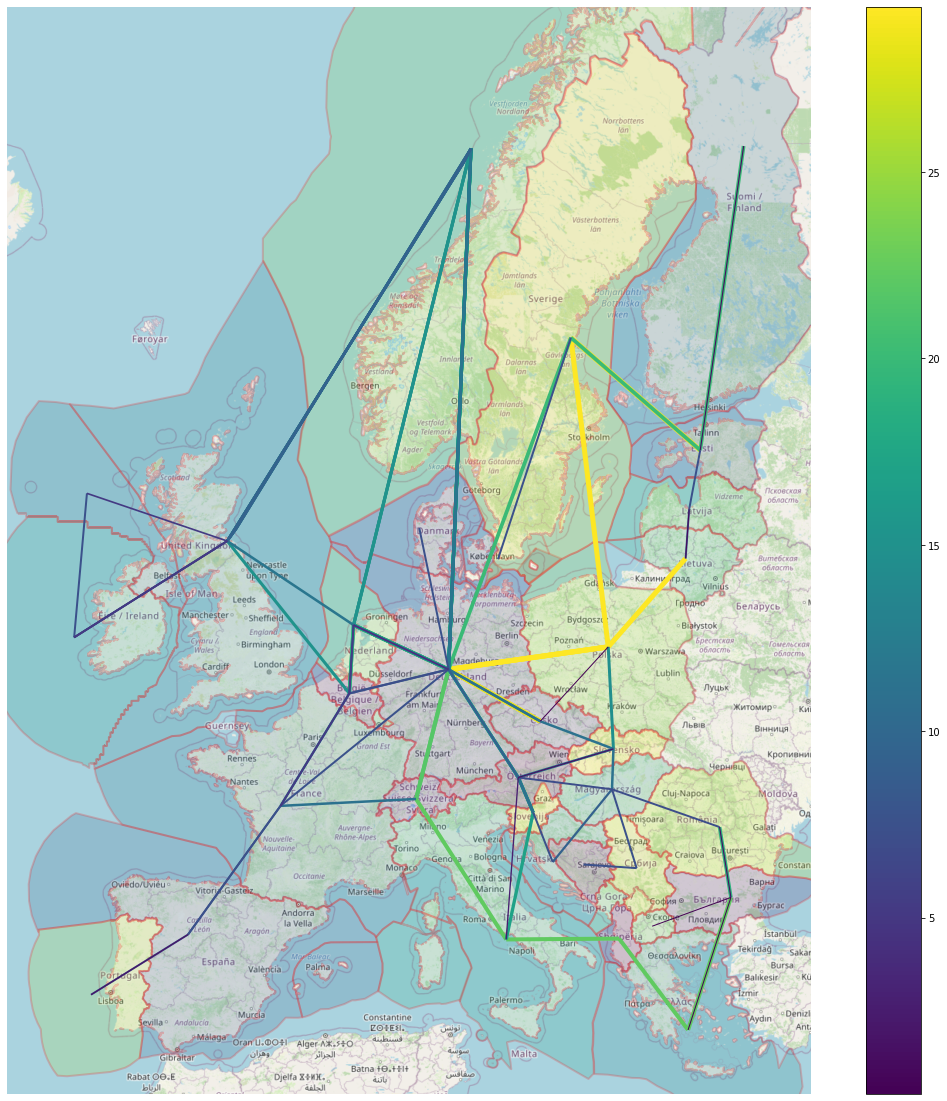

In [17]:
view(IGGIENL_dataset,IGGIENL_points)

100%|██████████| 37/37 [00:01<00:00, 29.07it/s]
/Users/wenruizhou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


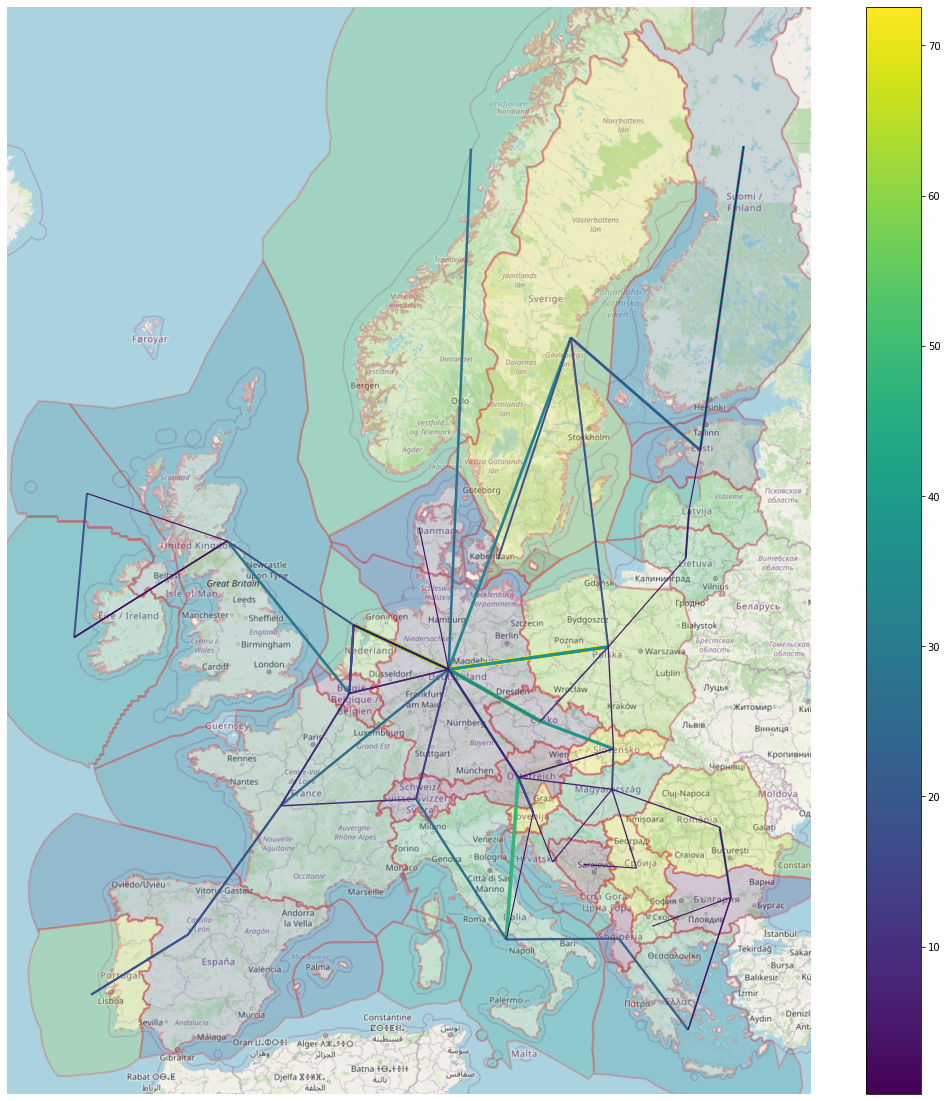

In [14]:
view(INETnew_dataset,INETnew_points)

100%|██████████| 989/989 [03:06<00:00,  5.31it/s]
/Users/wenruizhou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


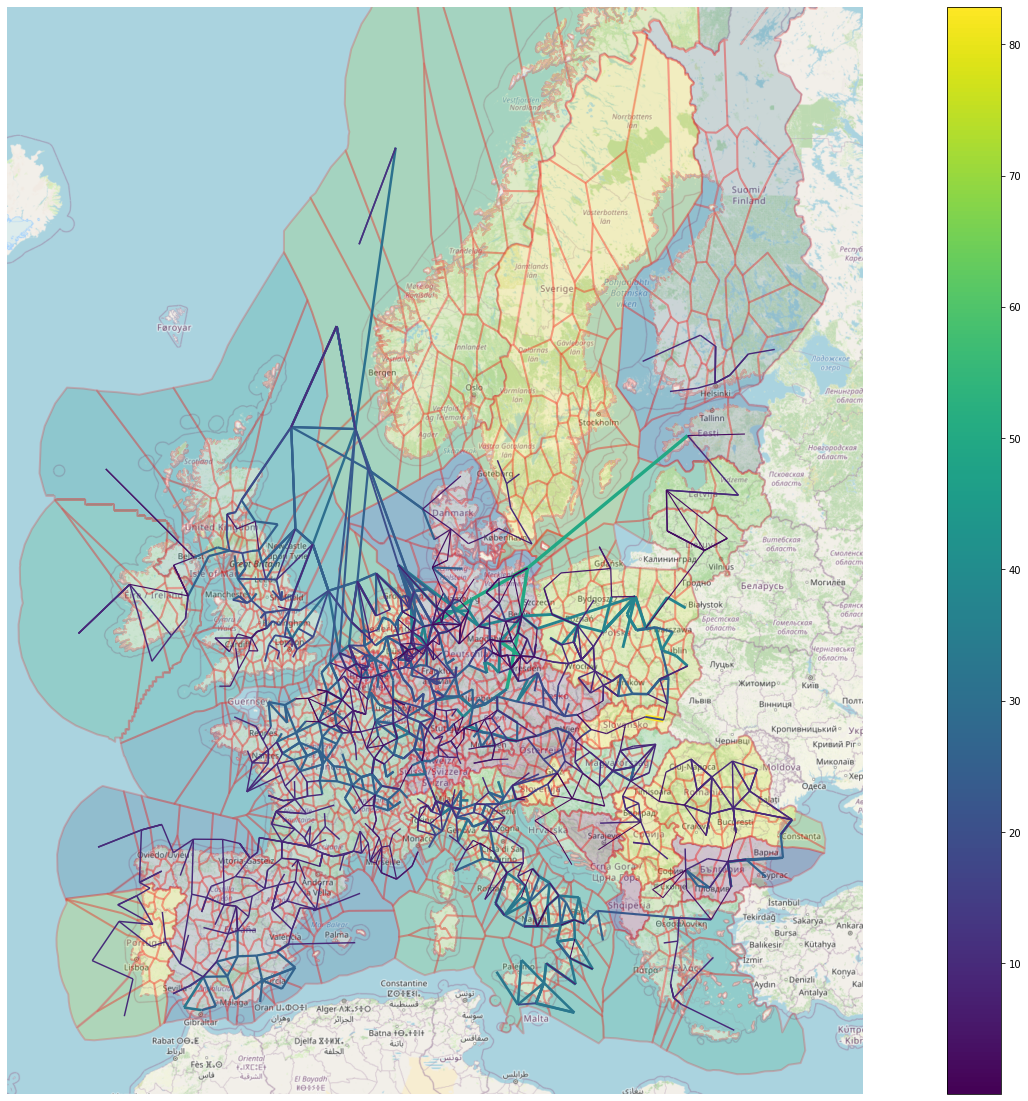

In [26]:
view(IGGIENL_dataset,IGGIENL_points)